# Online Retail ETL

This report presents the development of an end-to-end **ETL pipeline** using the *Online Retail* dataset, demonstrating the complete data lifecycle from extraction to visualization.

---

## Table of Contents
1. Introduction
2. Data Loading and Setup
3. Data Overview and EDA (Exploratory Data Analysis)
4. Data Cleaning & Transformation
5. Data Export and Database Loading
6. Power BI Connection and Visualisation
7. Conclusion

## 1. Introduction

This project presents the creation of an **ETL pipeline** based on the *Online Retail* dataset.

The project demonstrates the full data pipeline lifecycle — from raw data extraction and cleaning to loading and interactive dashboard creation in **Power BI**.

---

**Licence and Usage**

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.
This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

**Reference**

Chen, D. (2015). Online Retail [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5BW33.

---

**Objective**

The main objective is to build a mini data warehouse using **SQLite** for storage, and finally to connect the transformed data to **Power BI** for interactive visualization and reporting.

## 2. Data Loading and Setup

Firstly, the core Python libraries are imported:

- **pandas** - for data loading, cleaning, and manipulation
- **numpy** - for numerical computations and array operations
- **Faker** from **faker** - for generating realistic simulated personal information
- **matplotlib.pyplot** - for creating static data visualizations
- **seaborn** - for high-level, aesthetically enhanced statistical plots
- **create_engine** from **SQLAlchemy** - for creating a mini data warehouse
- **Counter** from **collections** and **re** - to explore and preprocessing object-type data

To ensure visual consistency across plots, the preferred plotting styles are configured at the beginning of the notebook.

---

**Dataset Feature Overview**

In the original *Online Retail* dataset following features are present:

- **`InvoiceNo`:** Unique identifier for each invoice (6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation)
- **`StockCode`:** Unique identifier for each distinct product (5-digit integral number uniquely assigned to each distinct product)
- **`Description`:** Product name
- **`Quantity`:** The quantities of each product (item) per transaction
- **`InvoiceDate`:** The day and time when each transaction was generated
- **`UnitPrice`:** Product price per unit
- **`CustomerID`:** Unique identifier for each customer
- **`Country`:** The name of the country where each customer resides

For educational purposes, and to enrich the analysis in the mini data warehouse, additional **synthetic customer data** will be generated using the **Faker** library.  
All modifications will be performed transparently, and the **original dataset will be preserved**.

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

from sqlalchemy import create_engine
from pathlib import Path
from IPython.display import Image, display

In [2]:
plt.style.use('ggplot')
sns.set_theme(style="ticks", palette="muted",
              rc={"axes.titlesize":14, "axes.labelsize":12})

In [3]:
df = pd.read_excel('../data/raw/Online Retail-copy.xlsx')
df_copy = df.copy()

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


## 3. Data Overview and EDA (Exploratory Data Analysis)

The original dataset contains **541,909 rows** and **8 columns**.

Initial inspection of data types shows that **`InvoiceNo`** is of object type, which may require verification.

Missing values are present in **`Description`** and **`CustomerID`**. Rows without **`CustomerID`** will be dropped in the next step, as further analysis is not possible without it. The missing values in **`Description`** will be investigated further during data cleaning.

Potential outliers and the values below zero may exist in **`Quantity`** and **`UnitPrice`**, which will be handled in the transformation phase.

Comparing the number of entries in **`CustomerID`** and the number of unique **`CustomerID`** values shows that some clients performed multiple transactions.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


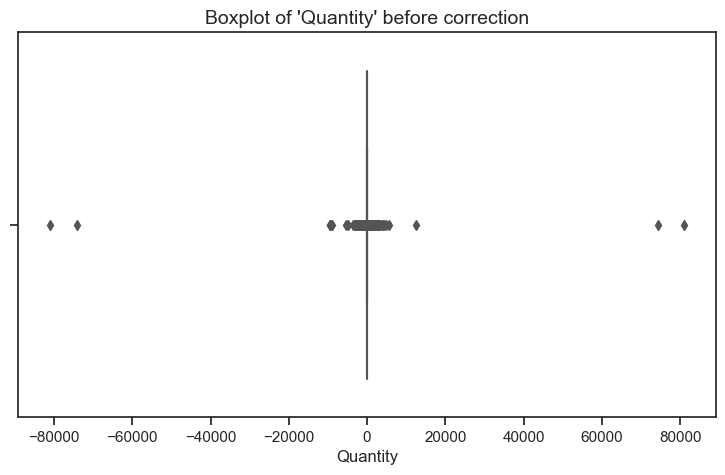

In [6]:
plt.figure(figsize = (9,5))
sns.boxplot(data = df, x = 'Quantity')
plt.title("Boxplot of 'Quantity' before correction")
plt.show()

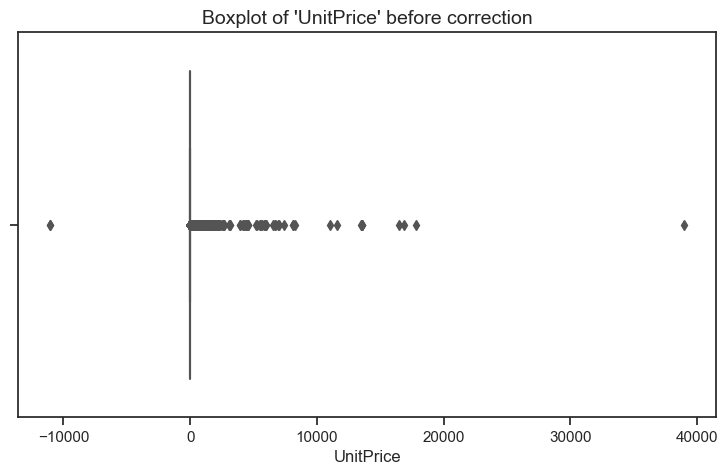

In [7]:
plt.figure(figsize = (9,5))
sns.boxplot(data = df, x = 'UnitPrice')
plt.title("Boxplot of 'UnitPrice' before correction")
plt.show()

In [8]:
df['CustomerID'].value_counts().head(10)

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
15311.0    2491
14646.0    2085
13089.0    1857
13263.0    1677
14298.0    1640
Name: CustomerID, dtype: int64

## 4. Data Cleaning & Transformation

The original dataset contained duplicated records, which were automatically removed.  
The same approach was applied to rows without **`CustomerID`**, as they corresponded to internal adjustments or data entry errors.  
After these operations, it was confirmed that no missing data remained in **`Description`**, ensuring that valid product records were retained.

**`InvoiceNo`** and **`StockCode`** were checked to detect credit notes and incorrect entries. Records corresponding to such cases were removed from the dataset, as they are not relevant for typical online retail analysis.

Negative values in **`UnitPrice`** and **`Quantity`** were eliminated, as they do not represent valid customer sales and likely resulted from data entry errors.

The same approach was applied to sales records identified as outliers based on boxplot observations. A threshold of 100 was chosen according to the 75th percentile and maximum values reported by **`df.describe()`**. Alternatively, statistical outlier rejection using the IQR method could be applied.

As mentioned in the introduction, for educational purposes and the creation of a mini data warehouse, the original dataset was divided into one fact table — **`sales_df`** — and three dimension tables: **`customers_df`**, **`countries_df`**, and **`products_df`**.

To enrich the analysis, the **`customers_df`** table was augmented with additional synthetic personal information generated using the **Faker** library, including **first name**, **last name**, **gender**, and **date of birth**.

Additionally, in a real data warehouse, product classification is a fundamental part of the data model, enabling aggregation and comparative analysis (e.g., “Sales by Product Category” dashboards in Power BI). However, the column **ProductCategory** did not originally exist in the source dataset.
Therefore, during the creation of **`products_df`** from the *Online Retail* dataset, this column was added to demonstrate how data engineers and analysts can prepare dimension tables for reporting purposes. The categorization is illustrative, aiming to provide more meaningful aggregation options for visualization and analysis.

In [9]:
duplicate_rows = df.duplicated().sum()
print (f"Number of duplicated rows: {duplicate_rows}")

Number of duplicated rows: 5268


In [10]:
df.drop_duplicates(inplace = True)
duplicate_rows = df.duplicated().sum()
print (f"Number of duplicated rows after drop: {duplicate_rows}")

Number of duplicated rows after drop: 0


In [11]:
customerid_nan = len(df[df['CustomerID'].isna()])
print (f"Number of missing 'CustomerID': {customerid_nan}")

Number of missing 'CustomerID': 135037


In [12]:
df.dropna(subset = ['CustomerID'], inplace = True)
customerid_nan = len(df[df['CustomerID'].isna()])
print (f"Number of missing 'CustomerID' after correction: {customerid_nan}")

Number of missing 'CustomerID' after correction: 0


In [13]:
df[df['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
description_nan = len(df[df['Description'].isna()])
print (f"Number of missing 'Description': {description_nan}")

Number of missing 'Description': 0


In [15]:
invoice_letter_counter = Counter(re.findall(r'\D', ''.join(df['InvoiceNo'].astype(str))))
print(f"Letters in 'InvoiceNo': {invoice_letter_counter}")

Letters in 'InvoiceNo': Counter({'C': 8872})


In [16]:
stock_letter_counter = Counter(re.findall(r'\D', ''.join(df['StockCode'].astype(str))))
print(f"Letters in 'StockCode': {stock_letter_counter}")

Letters in 'StockCode': Counter({'B': 9331, 'A': 8437, 'C': 4277, 'S': 2472, 'D': 2412, 'L': 2004, 'P': 1823, 'E': 1546, 'F': 1348, 'T': 1217, 'O': 1213, 'G': 1074, 'M': 762, 'N': 454, 'K': 350, 'H': 222, 'U': 181, 'J': 133, 'W': 125, 'R': 96, 'V': 37, ' ': 12, 'Y': 3, 'I': 3, 'Z': 1})


In [17]:
df = df[df['StockCode'].astype(str).str.match('^[0-9]+$', na=False)]
stock_letter_counter = Counter(re.findall(r'\D', ''.join(df['StockCode'].astype(str))))
print(f"Letters in 'StockCode' after drop: {stock_letter_counter}")

Letters in 'StockCode' after drop: Counter()


In [18]:
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'], errors='coerce')
df['StockCode'] = pd.to_numeric(df['StockCode'], errors='coerce')

In [19]:
print (f"'InvoiceNo' dtype: {df['InvoiceNo'].dtype}")
print (f"'StockCode' dtype: {df['StockCode'].dtype}")

'InvoiceNo' dtype: float64
'StockCode' dtype: int64


In [20]:
print (f" Number of negative 'Unit Price' or 'Quantity': {len(df[(df['UnitPrice'] < 0) | (df['Quantity'] < 0)])}")

 Number of negative 'Unit Price' or 'Quantity': 7870


In [21]:
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]
print (f" Number of negative 'Unit Price' or 'Quantity' after correction: {len(df[(df['UnitPrice'] < 0) | (df['Quantity'] < 0)])}")

 Number of negative 'Unit Price' or 'Quantity' after correction: 0


In [22]:
df = df[df['Quantity'] < 100]
df = df[df['UnitPrice'] <100]

print (f" Number of records after outliers after correction: {len(df)}")

 Number of records after outliers after correction: 352348


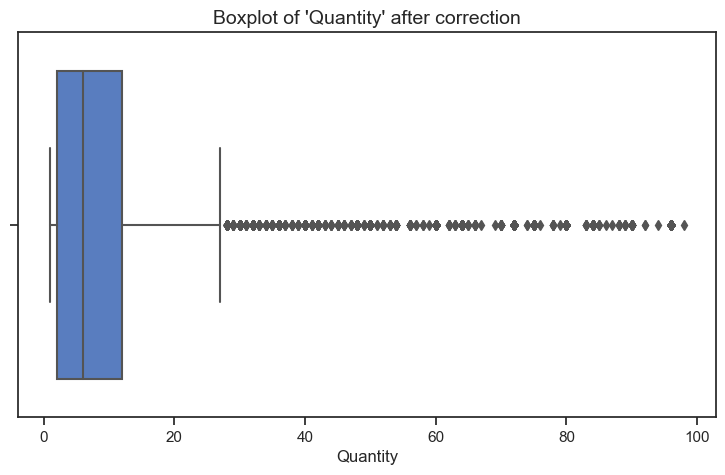

In [23]:
plt.figure(figsize = (9,5))
sns.boxplot(data = df, x = 'Quantity')
plt.title("Boxplot of 'Quantity' after correction")
plt.show()

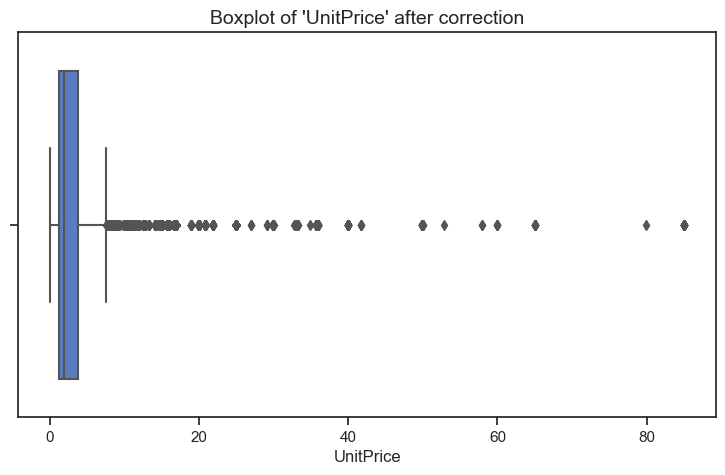

In [24]:
plt.figure(figsize = (9,5))
sns.boxplot(data = df, x = 'UnitPrice')
plt.title("Boxplot of 'UnitPrice' after correction")
plt.show()

In [25]:
df['Country'].value_counts()

United Kingdom          314586
Germany                   8021
France                    7577
EIRE                      6309
Spain                     2193
Belgium                   1789
Switzerland               1646
Netherlands               1469
Portugal                  1334
Norway                     962
Australia                  822
Channel Islands            701
Italy                      693
Cyprus                     552
Finland                    522
Austria                    355
Denmark                    328
Sweden                     302
Poland                     300
Japan                      263
Israel                     218
Unspecified                218
Singapore                  194
USA                        167
Iceland                    161
Greece                     135
Canada                     124
Malta                       89
United Arab Emirates        66
RSA                         54
European Community          53
Lebanon                     43
Lithuani

fake = Faker('en_GB')
n = len(df)

df['FirstName'] = [fake.first_name() for _ in range(n)]
df['LastName'] = [fake.last_name() for _ in range(n)]

In [26]:
customers_df = df[['CustomerID']].drop_duplicates().reset_index(drop = True)

fake = Faker('en_GB')
Faker.seed(42)
n = len(customers_df)

genders = []
first_names = []
last_names = []
birth_dates = []

for _ in range(n):
    gender = fake.random_element(elements=('Female', 'Male'))
    if gender == 'Female':
        first_name = fake.first_name_female()
    else:
        first_name = fake.first_name_male()
    
    last_name = fake.last_name()
    birth_date = fake.date_of_birth(minimum_age=18, maximum_age=75)
    
    genders.append(gender)
    first_names.append(first_name)
    last_names.append(last_name)
    birth_dates.append(birth_date)

customers_df['Gender'] = genders
customers_df['FirstName'] = first_names
customers_df['LastName'] = last_names
customers_df['BirthDate'] = birth_dates

customers_df.tail(3)

,CustomerID,Gender,FirstName,LastName,BirthDate
4263,13298.0,Male,Arthur,Dickinson,1985-11-03
4264,14569.0,Female,Marion,Moran,1999-08-16
4265,12713.0,Female,Carole,Robson,1990-01-28


In [27]:
print(f"customers_df shape: {customers_df.shape}")

customers_df shape: (4266, 5)


In [28]:
countries_df = df[['Country']].drop_duplicates().reset_index(drop=True)
countries_df['CountryID'] = range(1, len(countries_df) + 1)

countries_df.head(3)

,Country,CountryID
0,United Kingdom,1
1,France,2
2,Australia,3


In [29]:
print(f"countries_df shape: {countries_df.shape}")

countries_df shape: (37, 2)


In [30]:
products_df = df.groupby('StockCode', as_index=False)['Description'].agg(lambda x: x.value_counts().idxmax())

def categories_products(description):
    desc = str(description).lower()
    if any(word in desc for word in ['mug', 'cup', 'glass', 'plate', 'mirror', 'bowl', 'teapot']):
        return 'Glass & Ceramics'
    elif any(word in desc for word in ['bag', 'clip', 'earring', 'hairclip']):
        return 'Bags & Accessories'
    elif any(word in desc for word in ['card', 'pencil', 'pen', 'notebook', 'paper']):
        return 'Stationery'
    elif any(word in desc for word in ['light', 'lamp', 'candle', 'frame', 'cushion', 'door hanger',
                                       'metal sign', 'shelf', 'drawer', 'cupboard']):
        return 'Lighting & Home Decor'
    elif any(word in desc for word in ['toy', 'game', 'doll']):
        return 'Toys & Games'
    elif any(word in desc for word in ['christmas', 'tree', 'party', 'birthday', 'gift', 'balloon']):
        return 'Christmas & Party'
    else:
        return 'Other'

products_df['ProductCategory'] = products_df['Description'].apply(categories_products)

products_df.head(3)

,StockCode,Description,ProductCategory
0,10002,INFLATABLE POLITICAL GLOBE,Other
1,10080,GROOVY CACTUS INFLATABLE,Other
2,10120,DOGGY RUBBER,Other


In [31]:
print(f"products_df shape: {products_df.shape}")

products_df shape: (2779, 3)


In [32]:
df = df.merge(countries_df, on = 'Country', how = 'left')

df.tail(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CountryID
352345,581587.0,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2
352346,581587.0,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2
352347,581587.0,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2


In [33]:
sales_df = df[['InvoiceNo', 'InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice', 'CustomerID', 'CountryID']].copy()

sales_df['Total'] = sales_df['Quantity'] * sales_df['UnitPrice']
sales_df['Year'] = sales_df['InvoiceDate'].dt.year
sales_df['Month'] = sales_df['InvoiceDate'].dt.month
sales_df['Weekday'] = sales_df['InvoiceDate'].dt.day_name()

sales_df.head()

,InvoiceNo,InvoiceDate,StockCode,Quantity,UnitPrice,CustomerID,CountryID,Total,Year,Month,Weekday
0,536365.0,2010-12-01 08:26:00,71053,6,3.39,17850.0,1,20.34,2010,12,Wednesday
1,536365.0,2010-12-01 08:26:00,22752,2,7.65,17850.0,1,15.30,2010,12,Wednesday
2,536365.0,2010-12-01 08:26:00,21730,6,4.25,17850.0,1,25.50,2010,12,Wednesday
3,536366.0,2010-12-01 08:28:00,22633,6,1.85,17850.0,1,11.10,2010,12,Wednesday
4,536366.0,2010-12-01 08:28:00,22632,6,1.85,17850.0,1,11.10,2010,12,Wednesday


In [34]:
print(f"sales_df shape: {sales_df.shape}")

sales_df shape: (352348, 11)


In [35]:
sales_df.describe()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,CountryID,Total,Year,Month
count,352348.000000,352348.000000,352348.000000,352348.000000,352348.000000,352348.000000,352348.000000,352348.000000,352348.000000
mean,560816.738497,26940.464444,9.350097,2.866409,15289.528520,1.736125,17.128743,2010.936679,7.640194
std,13069.570390,15619.995859,12.402353,3.048015,1711.434608,2.964781,27.108974,0.243540,3.401925
min,536365.000000,10002.000000,1.000000,0.060000,12347.000000,1.000000,0.060000,2010.000000,1.000000
25%,549548.000000,21974.000000,2.000000,1.250000,13959.000000,1.000000,4.950000,2011.000000,5.000000
50%,562133.000000,22605.000000,6.000000,1.950000,15157.000000,1.000000,11.900000,2011.000000,9.000000
75%,572229.000000,23170.000000,12.000000,3.750000,16791.000000,1.000000,18.960000,2011.000000,11.000000
max,581587.000000,90208.000000,98.000000,85.000000,18287.000000,37.000000,2353.680000,2011.000000,12.000000


## 5. Data Export and Database Loading

The cleaned and transformed datasets were exported as `.csv` files, serving as a staging layer in the mini data warehouse creation process.

Subsequently, all datasets were loaded into a **SQLite** database using the **SQLAlchemy** engine, forming a mini data warehouse.  
The warehouse structure consists of one fact table (**`sales`**) and three dimension tables (**`customers`**, **`products`**, and **`countries`**),  
which together provide the analytical foundation for Power BI reporting.

In [36]:
sales_df.to_csv('../data/processed/sales.csv', index=False)
customers_df.to_csv('../data/processed/customers.csv', index=False)
products_df.to_csv('../data/processed/products.csv', index=False)
countries_df.to_csv('../data/processed/countries.csv', index=False)

In [37]:
engine = create_engine('sqlite:///../data/warehouse/online_retail.db')

sales_df.to_sql('sales', con=engine, if_exists='replace', index=False)
customers_df.to_sql('customers', con=engine, if_exists='replace', index=False)
products_df.to_sql('products', con=engine, if_exists='replace', index=False)
countries_df.to_sql('countries', con=engine, if_exists='replace', index=False)

37

## 6. Power BI Connection and Visualisation

The previously  created **`online_retail.db`**  was connected to Power BI using a Python script integration.
This approach enables direct access to tables **sales**, **customers**, **products**, and **countries** without requiring an ODBC driver.

The connection allows for dynamic updates of the dashboard whenever the ETL pipeline refreshes the database.

Below is an example of Python script that can be used for SQLite database connection to Power BI:

```python
# Import Python libraries
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(r"C:\Users\YourName\<path_to_db>\online_retail.db")

# Load tables
sales_df = pd.read_sql_query("SELECT * FROM sales", conn)
customers_df = pd.read_sql_query("SELECT * FROM customers", conn)
products_df = pd.read_sql_query("SELECT * FROM products", conn)
countries_df = pd.read_sql_query("SELECT * FROM countries", conn)

conn.close()

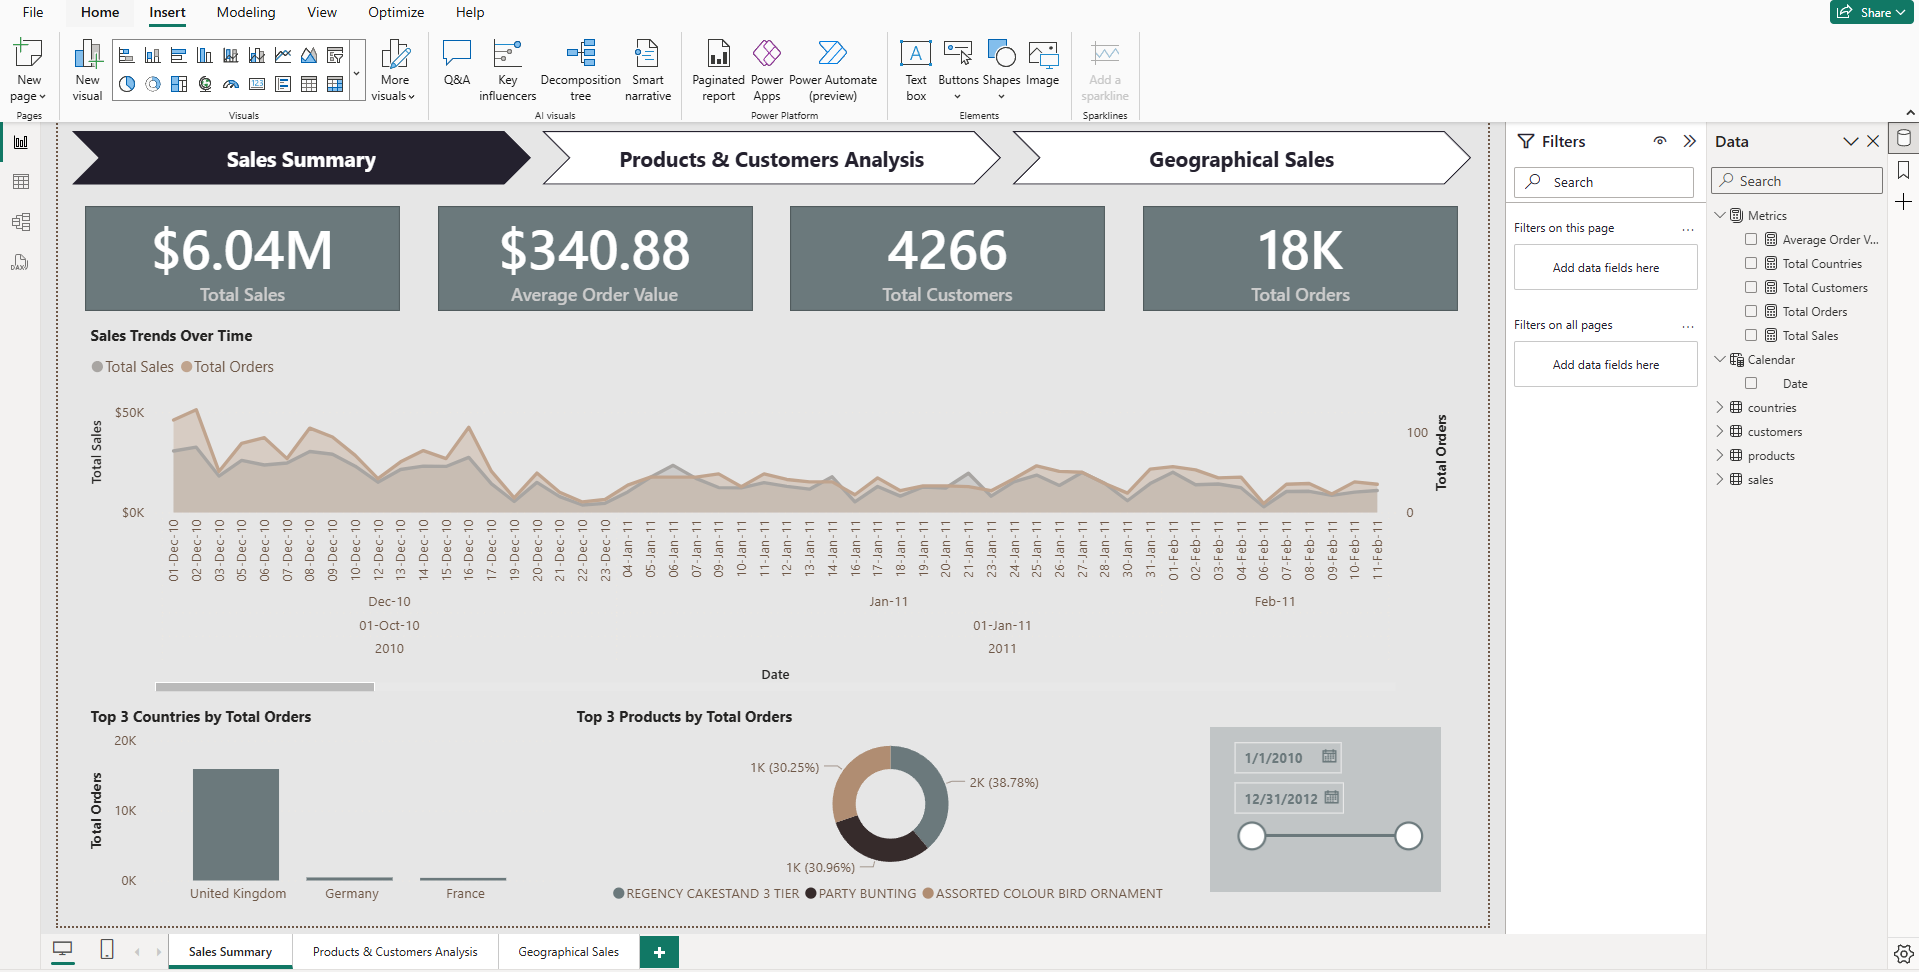

In [38]:
img_path = Path().resolve().parent / "images/Power_BI_Desktop_view.png"
display(Image(filename=img_path))

## 7. Conclusion

Using **Python** enabled the implementation of the complete **ETL** process — from data extraction, through cleaning and transformation, to loading into a **SQLite** database as a part of a **mini data warehouse**.

The dataset represents online transactions of a UK-based retail company collected between 2010 and 2011.

Most sales were generated in the United Kingdom, with smaller but still significant customer bases across other European countries.
The average basket value and transaction frequency varied across customer segments, indicating potential for targeted marketing strategies.

The resulting mini data warehouse was directly connected to **Power BI**, providing an interactive environment for analyzing sales by region, customer, and product category, and supporting key performance indicator (KPI) tracking.

As a potential future enhancement, the **Power BI Desktop** report can be published to **Power BI Service** with controlled access for stakeholders and automated data refresh enabled.

Full automation of the pipeline could be achieved by scheduling **SQLite** database updates using tools such as **Apache Airflow** or **cron**, which would regularly trigger the **Python ETL script**.